### Multinomial Logistic Regression

-- Installing Packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           classification_report, confusion_matrix)
import mlflow
import warnings
warnings.filterwarnings('ignore')

-- Load Data & Create Quality Groups

In [3]:
df = pd.read_csv("data/winequality-red.csv", sep=";")

def simplify_quality(q):
    if q <= 4:  # low
        return 0
    if q <= 6:  # medium
        return 1 
    else:  # high
        return 2

df["qualityg"] = df["quality"].apply(simplify_quality)


-- Prepare Data & Split data with stratification

In [7]:
X = df.drop(columns=["quality", "qualityg"])
y = df["qualityg"]

print("=== DATA PREPARATION ===")
print(f"Dataset shape: {df.shape}")
print(f"Features: {X.shape[1]}")
print(f"Target distribution: {np.bincount(y)}")
print(f"Target classes: Low (0), Medium (1), High (2)")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target distribution in training: {np.bincount(y_train)}")
print(f"Target distribution in test: {np.bincount(y_test)}")


=== DATA PREPARATION ===
Dataset shape: (1599, 13)
Features: 11
Target distribution: [  63 1319  217]
Target classes: Low (0), Medium (1), High (2)

Training set: (1279, 11)
Test set: (320, 11)
Target distribution in training: [  50 1055  174]
Target distribution in test: [ 13 264  43]


### Multinomial Regression with Preprocessing

-- Create Pipeline with scaling and multinomial Regression

In [9]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('multinomial_lr', LogisticRegression(solver='lbfgs', random_state=42))
])

-- Fit The Pipeline & Make Prediction

In [10]:
pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)

-- Calculate Metrics

In [11]:
accuracy_pipeline = accuracy_score(y_test, y_pred_pipeline)
precision_pipeline = precision_score(y_test, y_pred_pipeline, average='weighted', zero_division=0)
recall_pipeline = recall_score(y_test, y_pred_pipeline, average='weighted', zero_division=0)
f1_pipeline = f1_score(y_test, y_pred_pipeline, average='weighted', zero_division=0)

print("=== MULTINOMIAL LOGISTIC REGRESSION WITH PREPROCESSING ===")
print(f"Accuracy: {accuracy_pipeline:.4f}")
print(f"Precision: {precision_pipeline:.4f}")
print(f"Recall: {recall_pipeline:.4f}")
print(f"F1 Score: {f1_pipeline:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pipeline, target_names=['Low', 'Medium', 'High']))

=== MULTINOMIAL LOGISTIC REGRESSION WITH PREPROCESSING ===
Accuracy: 0.8438
Precision: 0.7975
Recall: 0.8438
F1 Score: 0.8168

Classification Report:
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00        13
      Medium       0.87      0.95      0.91       264
        High       0.60      0.42      0.49        43

    accuracy                           0.84       320
   macro avg       0.49      0.46      0.47       320
weighted avg       0.80      0.84      0.82       320



### Hyperparamater Tuning For Multinomial Regression

-- Parameter grid for hyperparameter Tuning & Create GridSearchCV object

In [12]:

param_grid = {
    'multinomial_lr__C': [0.1, 1, 10, 100],
    'multinomial_lr__max_iter': [500, 1000, 2000],
    'multinomial_lr__solver': ['lbfgs', 'newton-cg']
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

-- Grid Search

In [16]:
print("Performing hyperparameter tuning...")
grid_search.fit(X_train, y_train)

Performing hyperparameter tuning...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'multinomial_lr__C': [0.1, 1, ...], 'multinomial_lr__max_iter': [500, 1000, ...], 'multinomial_lr__solver': ['lbfgs', 'newton-cg']}"
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


-- Getting the Best Parameter and Score

In [15]:
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Best parameters: {'multinomial_lr__C': 0.1, 'multinomial_lr__max_iter': 500, 'multinomial_lr__solver': 'lbfgs'}
Best cross-validation score: 0.8084


-- Using best model and calculated

In [19]:
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best, average='weighted', zero_division=0)
recall_best = recall_score(y_test, y_pred_best, average='weighted', zero_division=0)
f1_best = f1_score(y_test, y_pred_best, average='weighted', zero_division=0)

print("\n=== BEST MULTINOMIAL LOGISTIC REGRESSION MODEL ===")
print(f"Accuracy: {accuracy_best:.4f}")
print(f"Precision: {precision_best:.4f}")
print(f"Recall: {recall_best:.4f}")
print(f"F1 Score: {f1_best:.4f}")


=== BEST MULTINOMIAL LOGISTIC REGRESSION MODEL ===
Accuracy: 0.8375
Precision: 0.7875
Recall: 0.8375
F1 Score: 0.8065


### Cross-Validation For Multinomial Regression

-- Perform Cross-Validation on the Best Model

In [21]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='f1_weighted')

print("=== CROSS-VALIDATION RESULTS ===")
print(f"CV F1 Scores: {cv_scores}")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

=== CROSS-VALIDATION RESULTS ===
CV F1 Scores: [0.77051692 0.8071165  0.81944984 0.7911352  0.80124369]
Mean CV F1 Score: 0.7979 (+/- 0.0329)


-- Compare With Difference Solvers

In [22]:
solvers = ['lbfgs', 'newton-cg', 'sag', 'saga']
solver_scores = {}

print("\n=== SOLVER COMPARISON ===")
for solver in solvers:
    try:
        model_solver = Pipeline([
            ('scaler', StandardScaler()),
            ('multinomial_lr', LogisticRegression(solver=solver, max_iter=1000, random_state=42))
        ])
        scores = cross_val_score(model_solver, X, y, cv=5, scoring='f1_weighted')
        solver_scores[solver] = scores.mean()
        print(f"{solver}: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
    except Exception as e:
        print(f"{solver}: Error - {e}")


=== SOLVER COMPARISON ===
lbfgs: 0.8028 (+/- 0.0354)
newton-cg: 0.8028 (+/- 0.0354)
sag: 0.8028 (+/- 0.0354)
saga: 0.8028 (+/- 0.0354)


-- Find the Best Solver

In [23]:
if solver_scores:
    best_solver = max(solver_scores, key=solver_scores.get)
    print(f"\nBest solver: {best_solver} with score: {solver_scores[best_solver]:.4f}")


Best solver: lbfgs with score: 0.8028


### Feature Importance For Multinomial Regression

-- Get feature importance from the best model & calculate importance for each class

In [25]:
feature_names = X.columns
coefficients = best_model.named_steps['multinomial_lr'].coef_

class_names = ['Low', 'Medium', 'High']
feature_importance_df = pd.DataFrame(coefficients.T, index=feature_names, columns=class_names)

print("=== FEATURE IMPORTANCE BY CLASS ===")
print(feature_importance_df)

=== FEATURE IMPORTANCE BY CLASS ===
                           Low    Medium      High
fixed acidity         0.091455 -0.253425  0.161970
volatile acidity      0.568722 -0.122076 -0.446646
citric acid           0.044507 -0.100748  0.056241
residual sugar        0.125478 -0.212733  0.087255
chlorides             0.055026  0.156229 -0.211255
free sulfur dioxide  -0.190059 -0.004329  0.194388
total sulfur dioxide  0.007730  0.366835 -0.374566
density              -0.071851  0.240728 -0.168876
pH                    0.311051 -0.167380 -0.143671
sulphates            -0.257948 -0.169742  0.427689
alcohol              -0.414195 -0.168942  0.583137


Plot Feature importance for each class

<Figure size 1200x800 with 0 Axes>

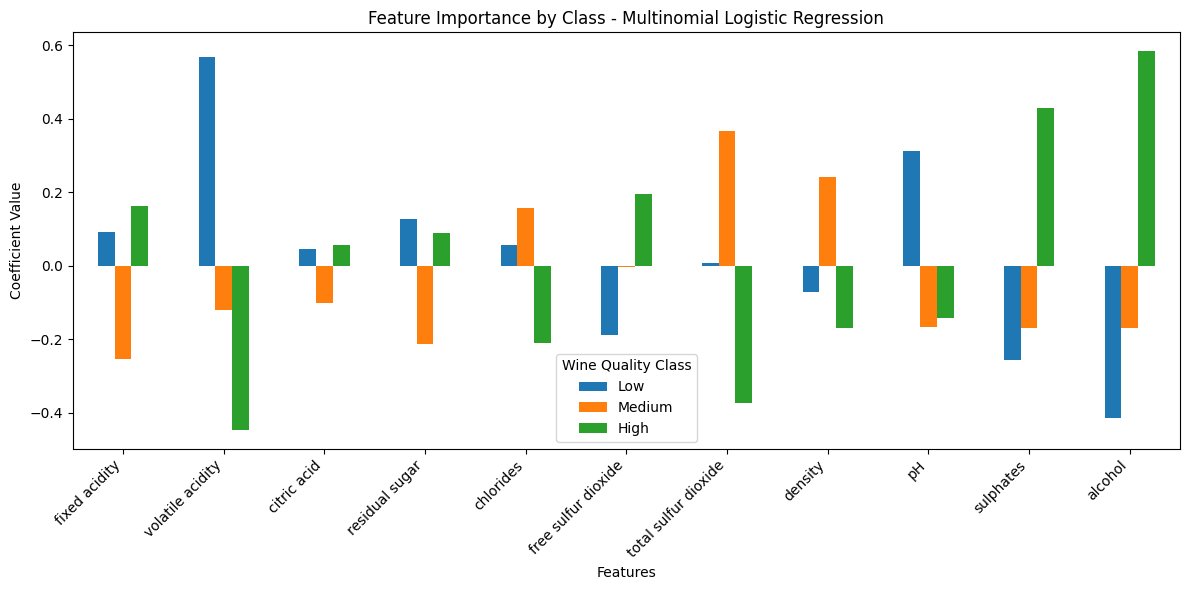

In [26]:
plt.figure(figsize=(12, 8))
feature_importance_df.plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance by Class - Multinomial Logistic Regression')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Wine Quality Class')
plt.tight_layout()
plt.show()

-- Overall Feature importance (average absolute coefficient across classes)

In [27]:
overall_importance = np.abs(coefficients).mean(axis=0)
feature_importance_overall = pd.DataFrame({
    'Feature': feature_names,
    'Importance': overall_importance
}).sort_values('Importance', ascending=False)

print("\n=== OVERALL FEATURE IMPORTANCE ===")
print(feature_importance_overall)


=== OVERALL FEATURE IMPORTANCE ===
                 Feature  Importance
10               alcohol    0.388758
1       volatile acidity    0.379148
9              sulphates    0.285126
6   total sulfur dioxide    0.249710
8                     pH    0.207368
0          fixed acidity    0.168950
7                density    0.160485
3         residual sugar    0.141822
4              chlorides    0.140837
5    free sulfur dioxide    0.129592
2            citric acid    0.067165


-- Plot overall feature importance

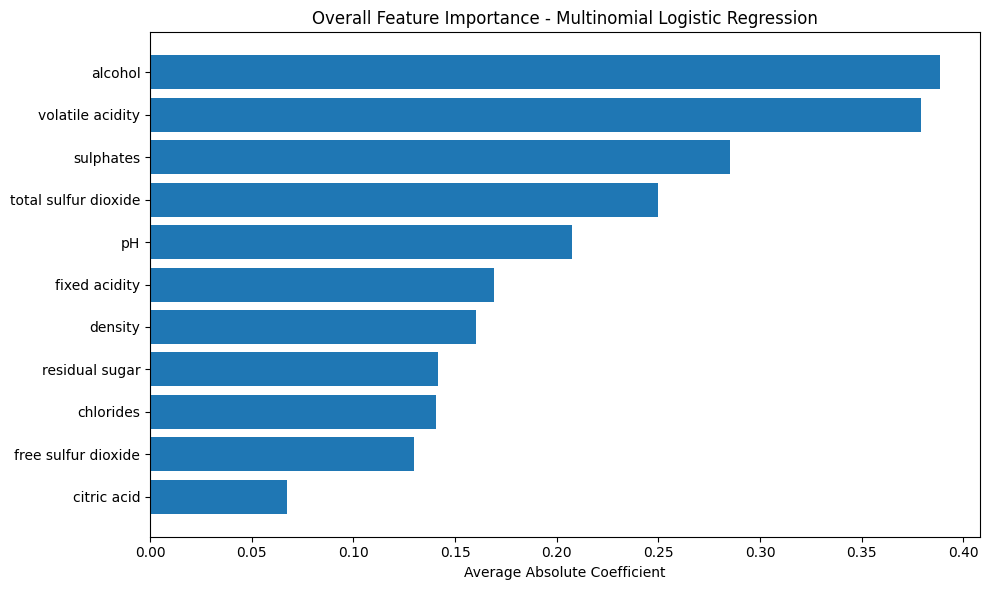

In [28]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_overall['Feature'], feature_importance_overall['Importance'])
plt.xlabel('Average Absolute Coefficient')
plt.title('Overall Feature Importance - Multinomial Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Confusion Matrix and Classification Analysis

-- Confusion Matrix for the best model and the plot

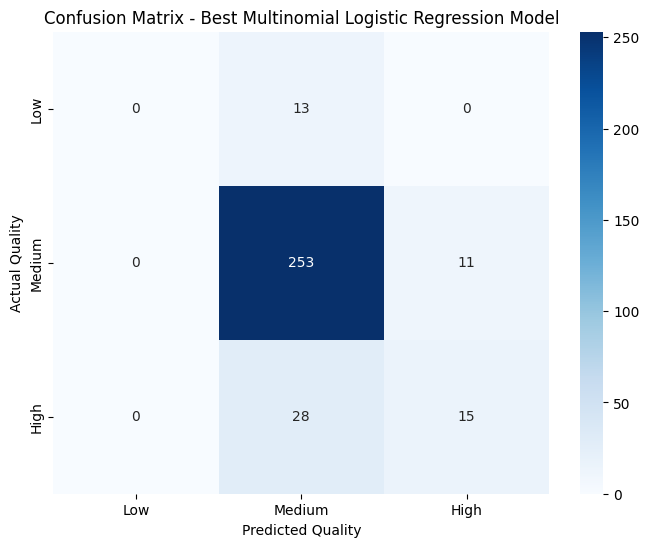

In [30]:
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Best Multinomial Logistic Regression Model')
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.show()

-- Class-wise Performance Analysis

In [31]:
print("=== CLASS-WISE PERFORMANCE ANALYSIS ===")
for i, class_name in enumerate(['Low', 'Medium', 'High']):
    class_precision = precision_score(y_test, y_pred_best, average=None, zero_division=0)[i]
    class_recall = recall_score(y_test, y_pred_best, average=None, zero_division=0)[i]
    class_f1 = f1_score(y_test, y_pred_best, average=None, zero_division=0)[i]
    
    print(f"\n{class_name} Quality Wines:")
    print(f"  Precision: {class_precision:.4f}")
    print(f"  Recall: {class_recall:.4f}")
    print(f"  F1-Score: {class_f1:.4f}")
    print(f"  Support: {np.sum(y_test == i)} samples")

=== CLASS-WISE PERFORMANCE ANALYSIS ===

Low Quality Wines:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 13 samples

Medium Quality Wines:
  Precision: 0.8605
  Recall: 0.9583
  F1-Score: 0.9068
  Support: 264 samples

High Quality Wines:
  Precision: 0.5769
  Recall: 0.3488
  F1-Score: 0.4348
  Support: 43 samples


-- Prediction Probabilities analysis

In [32]:
y_pred_proba_best = best_model.predict_proba(X_test)
print(f"\n=== PREDICTION PROBABILITIES ANALYSIS ===")
print(f"Average confidence for correct predictions: {np.mean(np.max(y_pred_proba_best, axis=1)):.4f}")
if np.sum(y_test != y_pred_best) > 0:
    print(f"Average confidence for incorrect predictions: {np.mean(np.max(y_pred_proba_best[y_test != y_pred_best], axis=1)):.4f}")


=== PREDICTION PROBABILITIES ANALYSIS ===
Average confidence for correct predictions: 0.8434
Average confidence for incorrect predictions: 0.7315


-- Compare with the original model

In [33]:
print("=== MODEL COMPARISON ===")
print("Original Model (Cell 16):")
print(f"  Accuracy: 0.8389")
print(f"  No preprocessing")
print(f"  Basic hyperparameters")

print("\nEnhanced Model (Current):")
print(f"  Accuracy: {accuracy_best:.4f}")
print(f"  With StandardScaler preprocessing")
print(f"  Optimized hyperparameters via GridSearchCV")
print(f"  Cross-validation F1: {cv_scores.mean():.4f}")

improvement = ((accuracy_best - 0.8389) / 0.8389) * 100
print(f"\nImprovement: {improvement:.2f}%")


=== MODEL COMPARISON ===
Original Model (Cell 16):
  Accuracy: 0.8389
  No preprocessing
  Basic hyperparameters

Enhanced Model (Current):
  Accuracy: 0.8375
  With StandardScaler preprocessing
  Optimized hyperparameters via GridSearchCV
  Cross-validation F1: 0.7979

Improvement: -0.17%
